In [90]:
import numpy as np
import matplotlib.pyplot as plt
from refractiveindex import RefractiveIndexMaterial
import pandas as pd

COEFFS = {
    "BK7": {
        "B": [1.03961212, 0.231792344, 1.01046945],
        "C": [0.00600069867, 0.0200179144, 103.560653]
    },
}

def sellmeier_index(material, wavelength):
    wl_um = wavelength * 1e6
    coeffs = COEFFS.get(material.upper())
    B = np.array(coeffs["B"])
    C = np.array(coeffs["C"])
    wl2 = wl_um ** 2
    if np.isscalar(wavelength):
        n2 = 1 + np.sum(B * wl2 / (wl2 - C))
        return np.sqrt(n2)
    else:
        n2 = 1 + np.sum(B[:, None] * wl2 / (wl2 - C[:, None]), axis=0)
        return np.sqrt(n2)

def get_metal_index(metal_type, wavelength_m):
    if metal_type.lower() == "gold":
        material = RefractiveIndexMaterial(shelf='main', book='Au', page='Johnson')
    elif metal_type.lower() == "silver":
        material = RefractiveIndexMaterial(shelf='main', book='Ag', page='Johnson')
    elif metal_type.lower() == "copper":
        material = RefractiveIndexMaterial(shelf='main', book='Cu', page='Johnson')
    # o pacote interpreta o valor em nanômetros se passar por exemplo: 633
    wavelength_um = wavelength_m / 1e-9
    n = material.get_refractive_index(wavelength_um)
    k = material.get_extinction_coefficient(wavelength_um)
    return complex(n, k)

def get_material_index(material: str, wavelength_m: float):
    wl_um = wavelength_m * 1e6  # Converter para micrômetros

    if material.upper() == "PC":
        """
        REFERENCES: |
            N. Sultanova, S. Kasarova, I. Nikolov.
            Dispersion properties of optical polymers.
            <a href="http://przyrbwn.icm.edu.pl/APP/ABSTR/116/a116-4-42.html"><i>Acta Physica Polonica A</i> <b>116</b>, 585-587 (2009)</a><br>
            (fit of the experimental data with the Sellmeier dispersion formula: Mikhail Polyanskiy)
        """
        material = RefractiveIndexMaterial(shelf='organic', book='polycarbonate', page='Sultanova')
        wavelength_um = wavelength_m / 1e-9
        n = material.get_refractive_index(wavelength_um)
        return n

    elif material.upper() == "H2O":
        """
        REFERENCES: |
        G. M. Hale and M. R. Querry.
        Optical constants of water in the 200-nm to 200-Âµm wavelength region.
        <a href="https://doi.org/10.1364/AO.12.000555"><i>Appl. Opt.</i> <b>12</b>, 555-563 (1973)</a><br>
        See also <a href="https://refractiveindex.info/?shelf=main&book=H2O&page=Segelstein"><i>Segelstein 1981</i></a> for more recent data from the same group.
        """
        material = RefractiveIndexMaterial(shelf='main', book='H2O', page='Hale')
        wavelength_um = wavelength_m / 1e-9
        n = material.get_refractive_index(wavelength_um)
        k = material.get_extinction_coefficient(wavelength_um)
        return complex(n, k)

    elif material.upper() == "BK7":
        """
        REFERENCES: |
        <a href="https://refractiveindex.info/download/data/2017/schott_2017-01-20b.agf">SCHOTT Zemax catalog 2017-01-20b</a>
        (obtained from <a href="https://www.schott.com/en-us/products/optical-glass-p1000267/downloads/">http://www.schott.com</a>)<br>
        See also <a href="https://refractiveindex.info/download/data/2017/schott_2017-01-20.pdf">SCHOTT glass data sheets</a>
        """
        material = RefractiveIndexMaterial(shelf='3d', book='glass', page='BK7')
        wavelength_um = wavelength_m / 1e-9
        n = material.get_refractive_index(wavelength_um)
        k = material.get_extinction_coefficient(wavelength_um)
        return complex(n, k)
    else:
        raise ValueError(f"Material '{material}' não encontrado.")

def get_fresnel(n, d, theta, wavelength):
    mu = np.ones(len(n))
    Mtot = np.eye(2, dtype=complex)
    epsilon = np.sqrt(n**2 - (n[0].real * np.sin(theta))**2)
    beta = 2 * np.pi / wavelength * d * epsilon
    q = np.sqrt(mu) * epsilon / n**2

    for k in range(1, len(n) - 1):
        Mk = np.array([
            [np.cos(beta[k]), -1j / q[k] * np.sin(beta[k])],
            [-1j * q[k] * np.sin(beta[k]), np.cos(beta[k])]
        ])
        Mtot = np.dot(Mtot, Mk)

    den = (Mtot[0, 0] + Mtot[0, 1] * q[-1]) * q[0] + (Mtot[1, 0] + Mtot[1, 1] * q[-1])
    r = ((Mtot[0, 0] + Mtot[0, 1] * q[-1]) * q[0] - (Mtot[1, 0] + Mtot[1, 1] * q[-1])) / den
    t = 2 * q[0] / den
    Rp = np.abs(r)**2

    return r, t, Rp

def build_layer_stack(layers, wavelength, Ef=0):
    """
    Constrói os vetores de índices de refração (n) e espessuras (d) com base nas camadas.
    """
    n = []
    d = []
    for layer in layers:
        if layer["type"] == "analyte":
            n.append(layer["index"])
            d.append(layer.get("thickness", 1e-6))  # default
        elif layer["type"] == "metal":
            n.append(get_metal_index(layer["name"], wavelength))
            d.append(layer["thickness"])
        elif layer["type"] == "prism":
            n.append(sellmeier_index(layer["name"], wavelength))
            d.append(layer["thickness"])
        elif layer["type"] == "other":
            n.append(get_material_index(layer["name"], wavelength))
            d.append(layer["thickness"])
        else:
            n.append(layer["index"])
            d.append(layer["thickness"])

    return np.array(n), np.array(d)

def simulate_spr(n, d, wavelength, angle_range_deg):
    theta_deg = np.array(angle_range_deg)
    theta_rad = np.deg2rad(theta_deg)
    r_arr = np.zeros(len(theta_rad), dtype=complex)
    t_arr = np.zeros(len(theta_rad), dtype=complex)
    Rp_arr = np.zeros(len(theta_rad))

    for i, theta in enumerate(theta_rad):
        r_arr[i], t_arr[i], Rp_arr[i] = get_fresnel(n, d, theta, wavelength)

    resonance_angle = theta_deg[np.argmin(Rp_arr)]

    return theta_deg, Rp_arr, resonance_angle

def plot_spr(x, Rp, angle_range, label='Analito', xlabel='Ângulo (°)'):
    plt.figure()
    # plt.figure(figsize=(8, 5))
    plt.plot(x, Rp, label=label, linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel('Refletância TM (a.u.)')

    if 'Ângulo' in xlabel:
        plt.title('Simulação SPR - Interrogação Angular')
        plt.xlim(angle_range[0], angle_range[-1])
    else:
        plt.title('Simulação SPR - Interrogação Espectral')
        plt.xlim(x[0], x[-1])

    plt.ylim(bottom=0)
    plt.yticks(np.arange(0, 1, 0.1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Resposta esperada do sensor e o ângulo de ressonância para quando se utiliza água como analito, para a primeira configuração utilizando um prisma BK7.


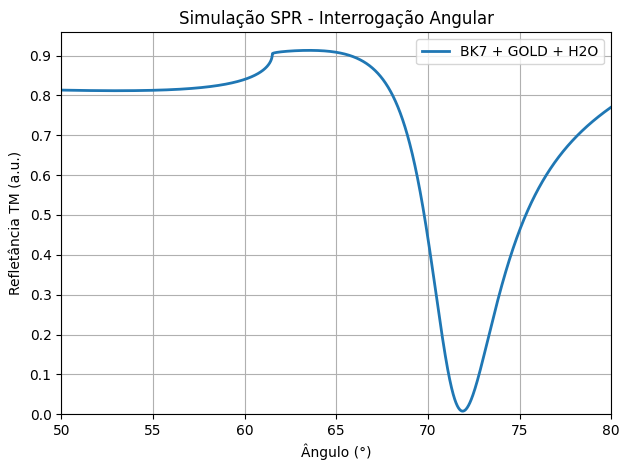


📌 Ângulo de ressonância: 71.90°
🔷 Índice de refração do prisma BK7: 1.51501+0.00000j
🟡 Índice de refração do ouro (n + ik): 0.18016+3.45315j
💧 Índice de refração da água: 1.332+0.000j


In [92]:
angle_range = np.arange(50, 80.0001, 0.01)
wavelength = 635e-9

layers = [
{"name": "BK7", "type": "other", "thickness": 500e-9}, # Hale and Querry (1973) para água, Johnson and Christy (1972) para os metais, Sultanova et al. (2009) para o PC
{"name": "gold", "type": "metal", "thickness": 50e-9},
{"name": "h2o", "type": "other", "thickness": 500e-9},
]

n, d = build_layer_stack(layers, wavelength)
theta_deg, Rp, angres = simulate_spr(n, d, wavelength, angle_range)

label = " + ".join([layer["name"].upper() for layer in layers if layer["type"] != "analyte"])
plot_spr(theta_deg, Rp, angle_range, label=label, xlabel="Ângulo (°)")
print(f"\n📌 Ângulo de ressonância: {angres:.2f}°")
print(f"🔷 Índice de refração do prisma {layers[0]["name"]}: {n[0]:.5f}")
print(f"🟡 Índice de refração do ouro (n + ik): {n[1]:.5f}")
print(f"💧 Índice de refração da água: {n[2]:.3f}")

Com o prisma de BK7 sendo substituído por um prisma de policarbonato (PC), foi possível determinar a resposta do sensor SPR considerando os demais parâmetros anteriormente definidos.

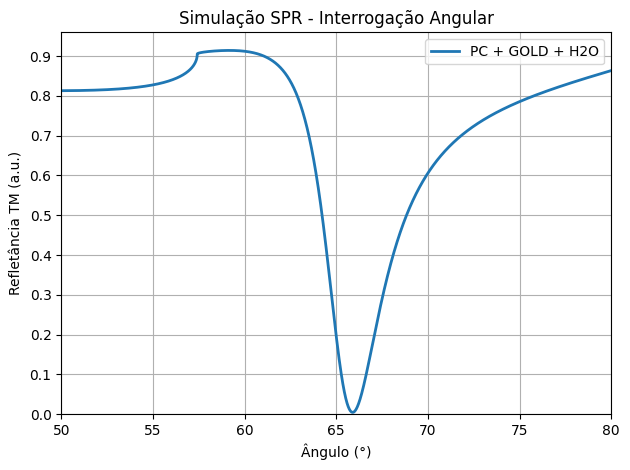


📌 Ângulo de ressonância (PC): 65.90°
🔷 Índice de refração do prisma PC: 1.58029+0.00000j
🟡 Índice de refração do ouro (n + ik): 0.18016+3.45315j
💧 Índice de refração da água: 1.332+0.000j


In [93]:
layers = [
{"name": "PC", "type": "other", "thickness": 500e-9},
{"name": "gold", "type": "metal", "thickness": 50e-9},
{"name": "h2o", "type": "other", "thickness": 500e-9},
]

n, d = build_layer_stack(layers, wavelength)
theta_deg, Rp, angres = simulate_spr(n, d, wavelength, angle_range)

label = " + ".join([layer["name"].upper() for layer in layers if layer["type"] != "analyte"])
plot_spr(theta_deg, Rp, angle_range, label=label, xlabel="Ângulo (°)")
print(f"\n📌 Ângulo de ressonância (PC): {angres:.2f}°")
print(f"🔷 Índice de refração do prisma {layers[0]["name"]}: {n[0]:.5f}")
print(f"🟡 Índice de refração do ouro (n + ik): {n[1]:.5f}")
print(f"💧 Índice de refração da água: {n[2]:.3f}")

Para identificar o melhor material metálico para o filme fino, foram simuladas diferentes combinações de metais e espessuras. Os critérios adotados foram:

Menor ângulo de ressonância ($\theta_{\text{res}}$)

Menor valor de reflectância no ângulo de ressonância ($R_p(\theta_{\text{res}})$)

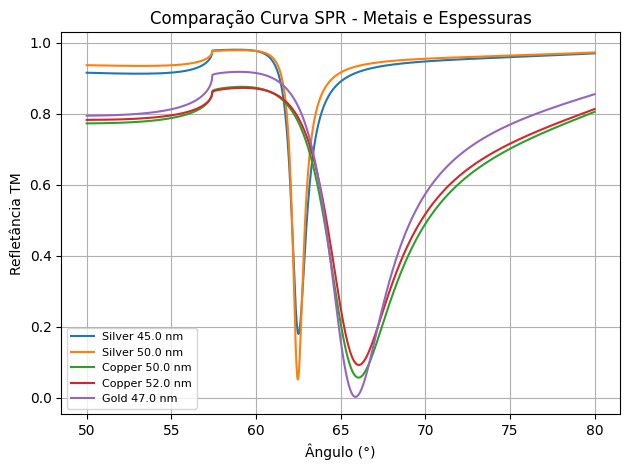


=== Melhores combinações (ordenado por θres e Rp) ===
Metal      | Esp. (nm)  | n        | k        | θres (°)   | Rp(θres)  
----------------------------------------------------------------------
Silver     | 50.0       | 0.05574  | 4.2931   | 62.47      | 0.05108   
Silver     | 45.0       | 0.05574  | 4.2931   | 62.51      | 0.17917   
Gold       | 47.0       | 0.18016  | 3.4531   | 65.88      | 0.00196   
Copper     | 50.0       | 0.26590  | 3.4360   | 66.06      | 0.05611   
Copper     | 52.0       | 0.26590  | 3.4360   | 66.07      | 0.09177   


In [95]:
angle_range = np.arange(50, 80.0001, 0.01)
wavelength = 635e-9

metal_thickness_map = {
    "silver": [45e-9, 50e-9],
    "copper": [50e-9, 52e-9],
    "gold": [47e-9]
}
metals_to_test = ["gold", "silver", "copper"]
results = []
plt.figure()

for metal, thicknesses in metal_thickness_map.items():
    for thickness in thicknesses:
        layers = [
            {"name": "PC", "type": "other", "thickness": 500e-9},  # Prisma
            {"name": metal, "type": "metal", "thickness": thickness},
            {"name": "h2o", "type": "other", "thickness": 500e-9},  # Analito
        ]

        n, d = build_layer_stack(layers, wavelength)
        theta_deg, Rp_arr, angres = simulate_spr(n, d, wavelength, angle_range)
        Rp_min = np.min(Rp_arr)

        metal_index = get_metal_index(metal, wavelength)
        results.append({
            "metal": metal.capitalize(),
            "thickness_nm": thickness  * 1e9,
            "n": metal_index.real,
            "k": metal_index.imag,
            "theta_res": angres,
            "Rp_min": Rp_min
        })

        plt.plot(theta_deg, Rp_arr, label=f"{metal.capitalize()} {thickness  * 1e9} nm")

plt.title("Comparação Curva SPR - Metais e Espessuras")
plt.xlabel("Ângulo (°)")
plt.ylabel("Refletância TM")
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

sorted_results = sorted(results, key=lambda x: (x["theta_res"], x["Rp_min"]))

print("\n=== Melhores combinações (ordenado por θres e Rp) ===")
print(f"{'Metal':<10} | {'Esp. (nm)':<10} | {'n':<8} | {'k':<8} | {'θres (°)':<10} | {'Rp(θres)':<10}")
print("-" * 70)
for res in sorted_results[:10]:
    print(f"{res['metal']:<10} | "
            f"{res['thickness_nm']:<10.1f} | "
            f"{res['n']:<8.5f} | "
            f"{res['k']:<8.4f} | "
            f"{res['theta_res']:<10.2f} | "
            f"{res['Rp_min']:<10.5f}")


Com base no melhor filme metálico definido na simulação anterior, foi determinada a resposta do sensor SPR para diferentes soluções de glicose com concentrações variando de 0 a 100 g/L. As curvas de reflectância foram simuladas e os seguintes parâmetros foram extraídos:

- Ângulo de ressonância ($\theta_{\text{res}}$)
- Reflectância mínima no ângulo de ressonância ($R_p(\theta_{\text{res}})$)
- Deslocamento angular em relação à primeira concentração ($\Delta \theta_{\text{res}}$)

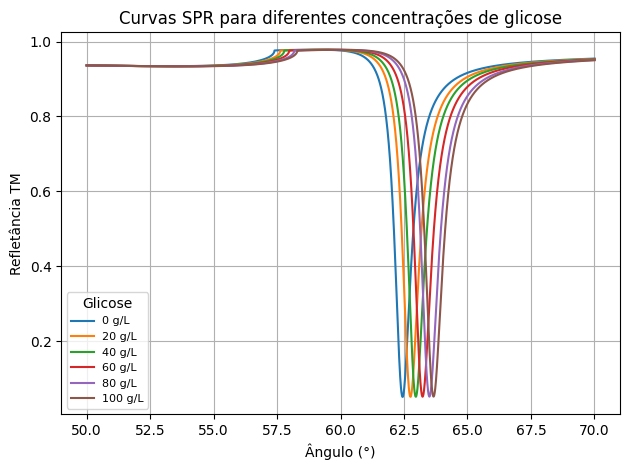


Tabela de Resultados:
 conc_gL     n_s theta_res Rp_min delta_theta
       0 1.33128     62.45 0.0511        0.00
      20 1.33469     62.76 0.0513        0.31
      40 1.33698     62.97 0.0514        0.52
      60 1.33985     63.23 0.0516        0.78
      80 1.34273     63.50 0.0517        1.05
     100 1.34446     63.67 0.0519        1.22


In [96]:
glicose_data = [
    {"conc_gL": 0,   "n": 1.33128},
    {"conc_gL": 20,  "n": 1.33469},
    {"conc_gL": 40,  "n": 1.33698},
    {"conc_gL": 60,  "n": 1.33985},
    {"conc_gL": 80,  "n": 1.34273},
    {"conc_gL": 100, "n": 1.34446},
]

angle_range = np.arange(50, 70.01, 0.01)
wavelength = 635e-9


metal = "silver"
metal_thickness = 50e-9

results = []
plt.figure()

for entry in glicose_data:
    n_s = entry["n"]
    layers = [
        {"name": "PC", "type": "other", "thickness": 500e-9},
        {"name": metal, "type": "metal", "thickness": metal_thickness},
        {"name": "glicose", "type": "analyte", "index": n_s},
    ]

    n, d = build_layer_stack(layers, wavelength)
    theta_deg, Rp_arr, angres = simulate_spr(n, d, wavelength, angle_range)
    Rp_min = np.min(Rp_arr)

    results.append({
        "conc_gL": entry["conc_gL"],
        "n_s": n_s,
        "theta_res": angres,
        "Rp_min": Rp_min
    })

    plt.plot(theta_deg, Rp_arr, label=f"{entry['conc_gL']} g/L")

plt.title("Curvas SPR para diferentes concentrações de glicose")
plt.xlabel("Ângulo (°)")
plt.ylabel("Refletância TM")
plt.grid(True)
plt.legend(title="Glicose", fontsize=8)
plt.tight_layout()
plt.show()

df = pd.DataFrame(results)
df["delta_theta"] = df["theta_res"] - df["theta_res"].iloc[0]
print("\nTabela de Resultados:")
print(df.to_string(index=False, formatters={
    "n_s": "{:.5f}".format,
    "theta_res": "{:.2f}".format,
    "Rp_min": "{:.4f}".format,
    "delta_theta": "{:.2f}".format
}))


Além disso, foram gerados dois gráficos adicionais:
- $\theta_{\text{res}}$ em função do índice de refração da solução
- $\theta_{\text{res}}$ em função da concentração de glicose

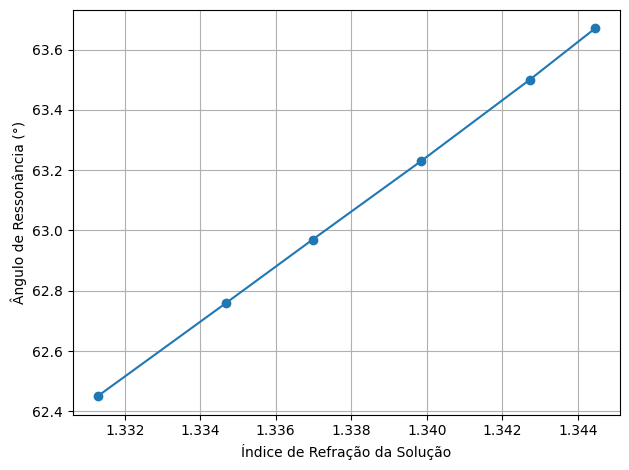

In [97]:
plt.figure()
plt.plot(df["n_s"], df["theta_res"], 'o-', label="θres vs n_s")
plt.xlabel("Índice de Refração da Solução")
plt.ylabel("Ângulo de Ressonância (°)")
plt.grid(True)
plt.tight_layout()
plt.show()

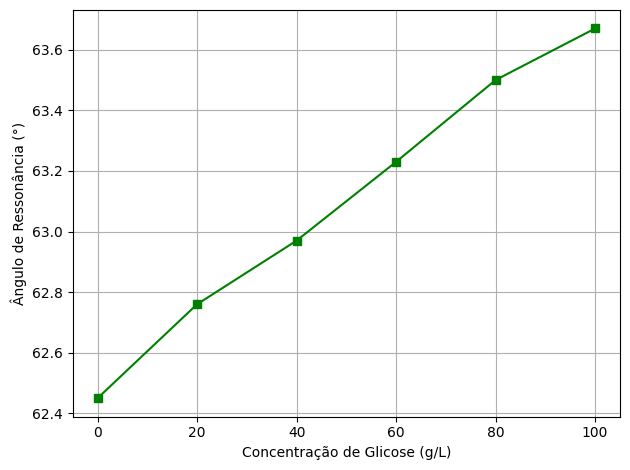

In [98]:
plt.figure()
plt.plot(df["conc_gL"], df["theta_res"], 's-', label="θres vs concentração", color='green')
plt.xlabel("Concentração de Glicose (g/L)")
plt.ylabel("Ângulo de Ressonância (°)")
plt.grid(True)
plt.tight_layout()
plt.show()

Para operar o sensor SPR no modo de interrogação espectral, foi substituído o laser monocromático por um LED policromático com faixa espectral entre 470 nm e 850 nm. Nessa configuração, o ângulo de incidência foi mantido fixo e a reflectância foi calculada para cada comprimento de onda dentro da faixa do LED.

Esse tipo de interrogação permite observar o comportamento espectral do sensor, identificando o comprimento de onda correspondente ao mínimo de reflectância, que está associado à condição de ressonância.

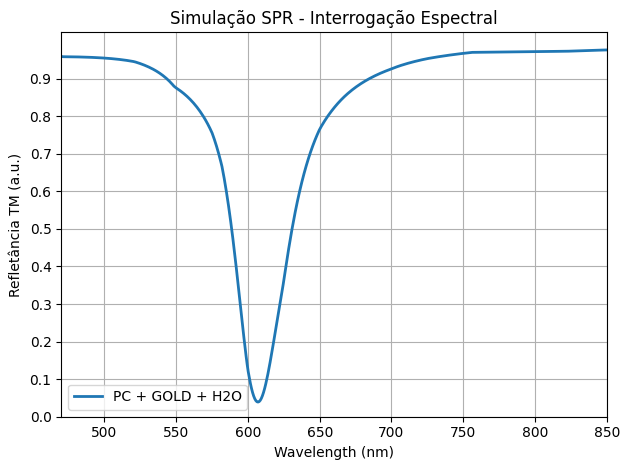

In [99]:
# Faixa espectral do LED policromático (470 nm a 850 nm)
lambda_range = np.linspace(470e-9, 850e-9, 500)
angle_fixed_deg = 63.0
angle_fixed_rad = np.radians(angle_fixed_deg)

metal = "silver"
metal_thickness = 50e-9  
Rp_spectral = []

for wl in lambda_range:
    layers = [
        {"name": "PC", "type": "other", "thickness": 500e-9},
        {"name": metal, "type": "metal", "thickness": metal_thickness},
        {"name": "h2o", "type": "other", "thickness": 500e-9},
    ]

    n, d = build_layer_stack(layers, wl)
    _ , Rp_arr, _ = simulate_spr(n, d, wl, np.array([angle_fixed_deg]))
    Rp_spectral.append(Rp_arr[0])

plot_spr(lambda_range * 1e9, Rp_spectral, angle_range, label=label, xlabel='Wavelength (nm)')

Para avaliar a precisão do modelo de Drude na descrição das propriedades ópticas da prata, foram comparadas as permissividades elétricas complexas obtidas experimentalmente por Johnson e Christy com aquelas calculadas teoricamente utilizando a equação de Drude.

A análise da parte real e imaginária da permissividade elétrica permite verificar a adequação do modelo de Drude para representar o comportamento óptico da prata na faixa espectral entre 470 nm e 850 nm.


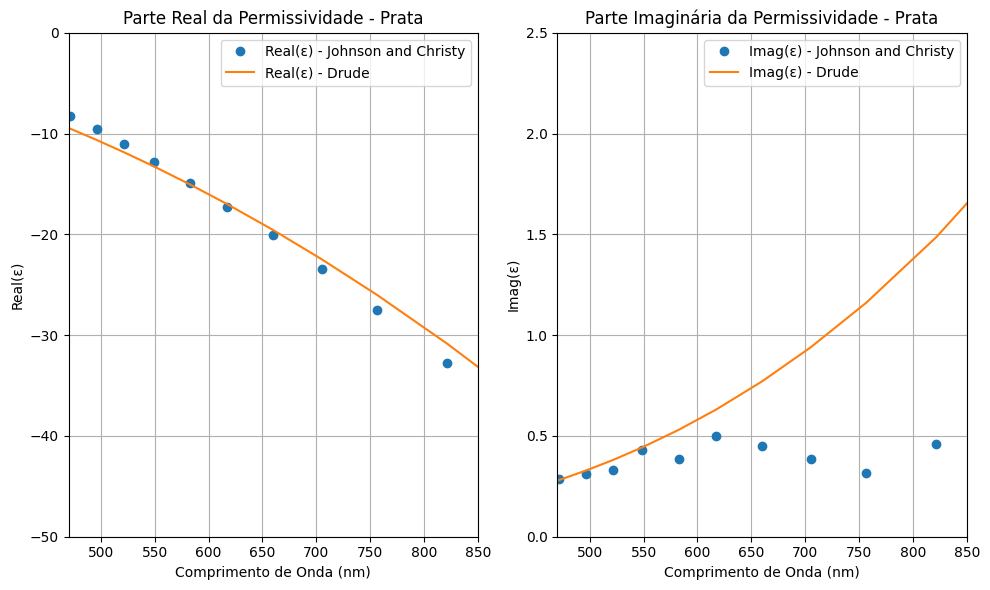

In [103]:
# Dados experimentais (Johnson & Christy)
wavelengths_silver = np.array([
    1216.3702965738592, 1088.3313179871373, 984.6807162740765, 892.5882751836954,
    821.6541076194281, 756.5229893325223, 704.9418764234866, 659.9455864390087,
    617.262538559869, 582.4871842748059, 548.9812842943967, 521.3015556745111,
    496.27908100213455, 471.7481758575424, 451.1628009110314, 430.79781336990845,
    413.56590083511213, 397.6595200337617
]) * 1e-9

# valores experimentais do indice de refração da prata
n_values_silver = np.array([
    0.09, 0.04, 0.04, 0.04, 0.04, 0.03, 0.04, 0.05, 0.06, 0.05, 0.06, 0.05,
    0.05, 0.05, 0.04, 0.04, 0.05, 0.05
])

k_values_silver = np.array([
    8.828, 7.795, 6.992, 6.312, 5.727, 5.242, 4.838, 4.483, 4.152, 3.858, 3.586,
    3.324, 3.093, 2.869, 2.657, 2.462, 2.275, 2.070
])

epsilon_exp_silver = (n_values_silver + 1j * k_values_silver) ** 2

# Modelo de Drude - parâmetros para prata
lambda_p = 0.14541e-6  # comprimento de onda de plasma (m)
lambda_c = 17.614e-6   # comprimento de onda de colisão (m)

# Cálculo da permissividade pela equação de Drude
epsilon_drude_silver = 1 - (wavelengths_silver ** 2) / (lambda_p ** 2 * (1 + 1j * wavelengths_silver / lambda_c))

plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.plot(wavelengths_silver * 1e9, epsilon_exp_silver.real, 'o', label='Real(ε) - Johnson and Christy')
plt.plot(wavelengths_silver * 1e9, epsilon_drude_silver.real, '-', label='Real(ε) - Drude')
plt.title("Parte Real da Permissividade - Prata")
plt.xlabel('Comprimento de Onda (nm)')
plt.ylabel('Real(ε)')
plt.xlim(470, 850)
plt.ylim(-50, 0)
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(wavelengths_silver * 1e9, epsilon_exp_silver.imag, 'o', label='Imag(ε) - Johnson and Christy')
plt.plot(wavelengths_silver * 1e9, epsilon_drude_silver.imag, '-', label='Imag(ε) - Drude')
plt.title("Parte Imaginária da Permissividade - Prata")
plt.xlabel('Comprimento de Onda (nm)')
plt.ylabel('Imag(ε)')
plt.xlim(470, 850)
plt.ylim(0, 2.5)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Comparação entre os valores experimentais da permissividade elétrica do BK7 e os valores teóricos obtidos por meio da equação de Sellmeier.

<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Pichau\AppData\Local\Temp\ipykernel_15560\1481231123.py:18: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Permissividade Elétrica ($\epsilon$)', fontsize=14)


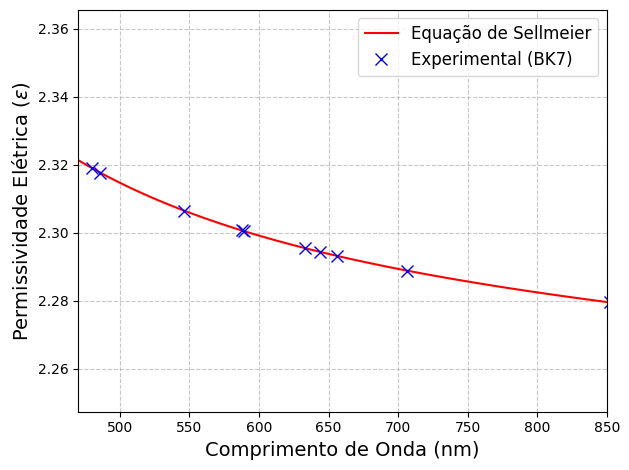

In [106]:
# Dados experimentais para o BK7
wavelengths_bk7_exp = np.array([1529.6, 1060.0, 1014.0, 852.1, 706.5, 656.3, 643.8, 632.8, 589.3, 587.6, 546.1, 486.1, 480.0, 435.8, 404.7, 365.0]) * 1e-9  # Convertendo para metros
n_values_bk7_exp = np.array([1.50091, 1.50669, 1.50731, 1.50980, 1.51289, 1.51432, 1.51472, 1.51509, 1.51673, 1.51680, 1.51872, 1.52238, 1.52283, 1.52668, 1.53024, 1.53627])

epsilon_exp_bk7 = n_values_bk7_exp ** 2

n_sellmeier_bk7 = []
for wl in lambda_range:
    n_bk7_theo = sellmeier_index("BK7", wl)
    n_sellmeier_bk7.append(n_bk7_theo)

epsilon_sellmeier_bk7 = np.array(n_sellmeier_bk7) **2

plt.figure()
plt.plot(lambda_range * 1e9, epsilon_sellmeier_bk7, '-', color='red', label='Equação de Sellmeier')
plt.plot(wavelengths_bk7_exp * 1e9, epsilon_exp_bk7, 'x', color='blue', markersize=8, linewidth=2, label='Experimental (BK7)')
plt.xlabel('Comprimento de Onda (nm)', fontsize=14)
plt.ylabel('Permissividade Elétrica ($\epsilon$)', fontsize=14)
plt.xlim(470, 850)  # Limitando o eixo x para 470 nm a 850 nm
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Dependendo da precisão requerida, é possível optar por utilizar índices de refração provenientes de modelos teóricos ou dados experimentais. Para materiais metálicos como a prata, pode-se empregar o modelo de Drude, enquanto para materiais dielétricos como o prisma de BK7, a equação de Sellmeier é comumente usada. Alternativamente, podem ser utilizados dados experimentais disponíveis na literatura, ex: Johnson and Christy (1972).

A fim de verificar o impacto da escolha dos índices de refração na resposta do sensor SPR, foi realizada uma simulação comparando a reflectância em função do ângulo de incidência para dois cenários:

- **Dados experimentais**: prata (Johnson & Christy) e BK7 (tabela de índice de refração).
- **Modelos teóricos**: prata (modelo de Drude) e BK7 (Sellmeier).



Ângulo de ressonância experimental: 67.60°
Ângulo de ressonância teórico: 67.80°
Índice de refração do prisma (BK7) experimental: 1.51501
Índice de refração do prisma (BK7) teórico: 1.51501
Índice de refração da prata (n + ik) experimental:0.05574 + 4.29308i
Índice de refração da prata (n + ik) com drude: 0.08080 + 4.24878i


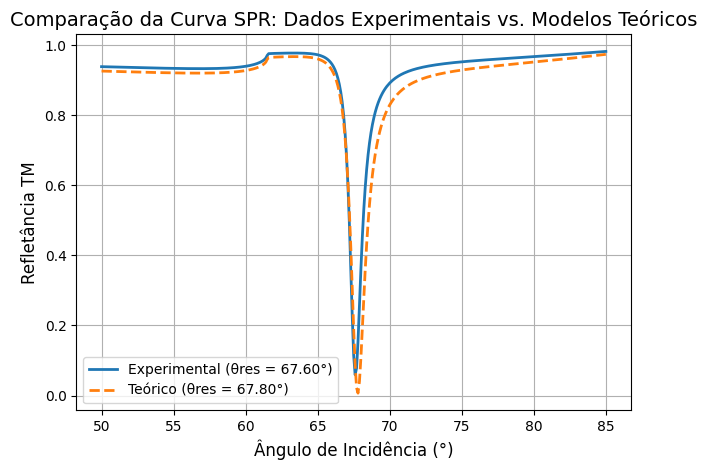

In [113]:
from scipy.interpolate import interp1d
angle_range = np.arange(50, 85.1, 0.1) 
wavelength = 635e-9

thickness_ag = 50e-9

def get_drude_index_silver(wavelength_m):
    lambda_p = 0.14541e-6  # m
    lambda_c = 17.614e-6   # m
    eps = 1 - (wavelength_m ** 2) / (lambda_p ** 2 * (1 + 1j * wavelength_m / lambda_c))
    n_complex = np.sqrt(eps)
    return n_complex

# ----------- Simulação com dados experimentais (Johnson e Christy para prata + BK7 n experimental) -----------
n_ag_exp = get_metal_index("silver", wavelength)

n_interp_bk7 = interp1d(wavelengths_bk7_exp, n_values_bk7_exp, kind='cubic')
n_bk7_exp = n_interp_bk7(wavelength)

#n_bk7_exp = np.interp(wavelength, wavelengths_bk7_exp, n_values_bk7_exp)

layers_exp = [
    {"name": "BK7", "type": "fixed", "index": n_bk7_exp, "thickness": 500e-9},
    {"name": "silver", "type": "fixed", "index": n_ag_exp, "thickness": thickness_ag},
    {"name": "h2o", "type": "other", "thickness": 500e-9}
]

n_exp, d_exp = build_layer_stack(layers_exp, wavelength)
theta_deg_exp, Rp_exp, theta_res_exp = simulate_spr(n_exp, d_exp, wavelength, angle_range)

# ----------- Simulação com modelos teóricos (Drude para prata + Sellmeier para BK7) -----------
n_ag_drude = get_drude_index_silver(wavelength)
n_bk7_theo = sellmeier_index("BK7", wavelength)

layers_theory = [
    {"name": "BK7", "type": "fixed", "index": n_bk7_theo, "thickness": 500e-9},
    {"name": "silver", "type": "fixed", "index": n_ag_drude, "thickness": thickness_ag},
    {"name": "h2o", "type": "other", "thickness": 500e-9}
]

n_theo, d_theo = build_layer_stack(layers_theory, wavelength)
theta_deg_theo, Rp_theo, theta_res_theo = simulate_spr(n_theo, d_theo, wavelength, angle_range)

print(f"Ângulo de ressonância experimental: {theta_res_exp:.2f}°")
print(f"Ângulo de ressonância teórico: {theta_res_theo:.2f}°")

print(f"Índice de refração do prisma (BK7) experimental: {n_bk7_exp:.5f}")
print(f"Índice de refração do prisma (BK7) teórico: {n_bk7_theo:.5f}")
print(f"Índice de refração da prata (n + ik) experimental:{n_ag_exp.real:.5f} + {n_ag_exp.imag:.5f}i")
print(f"Índice de refração da prata (n + ik) com drude: {n_ag_drude.real:.5f} + {n_ag_drude.imag:.5f}i")

plt.plot(theta_deg_exp, Rp_exp, label=f'Experimental (θres = {theta_res_exp:.2f}°)', linewidth=2)
plt.plot(theta_deg_theo, Rp_theo, '--', label=f'Teórico (θres = {theta_res_theo:.2f}°)', linewidth=2)
plt.xlabel("Ângulo de Incidência (°)", fontsize=12)
plt.ylabel("Refletância TM", fontsize=12)
plt.title("Comparação da Curva SPR: Dados Experimentais vs. Modelos Teóricos", fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


#### Avaliação dos Efeitos do Aquecimento do Chip na Resposta do Sensor

A temperatura pode afetar significativamente a resposta de um sensor SPR, especialmente devido à variação do índice de refração dos materiais com o aumento da temperatura. No caso do prisma BK7, essa dependência térmica pode ser descrita por uma equação que leva em conta coeficientes empíricos.

Utilizou-se a seguinte equação para calcular o índice de refração do BK7 em função da temperatura \( T \):

$$
\Delta n = \left(\frac{n_0^2 - 1}{2n_0}\right) \left[D_0 \Delta T + D_1 \Delta T^2 + D_2 \Delta T^3 + \frac{E_0 \Delta T + E_1 \Delta T^2}{\lambda^2 - \lambda_0^2}\right]
$$


Foram simuladas curvas SPR para diferentes temperaturas (25 °C, 50 °C, 75 °C e 100 °C), mantendo-se fixos o comprimento de onda (635 nm) e a espessura da prata. O objetivo é verificar a mudança do ângulo de ressonância  ($\theta_{\text{res}}$) com a elevação da temperatura.


Temperatura: 25°C
Índice de Refração do BK7 (n): 1.5150212040761282
Ângulo de Ressonância: 67.62°
Menor Valor de Reflectância (Rp) em 67.62°: 0.05726884025755347
----------------------------------------
Temperatura: 50°C
Índice de Refração do BK7 (n): 1.5150588415259194
Ângulo de Ressonância: 67.62°
Menor Valor de Reflectância (Rp) em 67.62°: 0.05724463590995099
----------------------------------------
Temperatura: 75°C
Índice de Refração do BK7 (n): 1.515103715108653
Ângulo de Ressonância: 67.62°
Menor Valor de Reflectância (Rp) em 67.62°: 0.05733022307851474
----------------------------------------
Temperatura: 100°C
Índice de Refração do BK7 (n): 1.5151552757829507
Ângulo de Ressonância: 67.61°
Menor Valor de Reflectância (Rp) em 67.61°: 0.05723430938286067
----------------------------------------


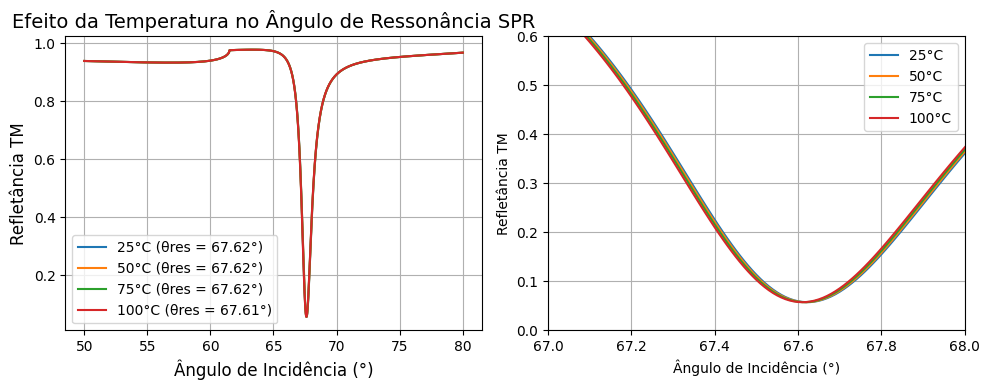

In [115]:
# Parâmetros já definidos
wavelength = 635e-9  # m
wavelength_microns = wavelength * 1e6
thickness_ag = 50e-9
angle_range = np.arange(50, 80.01, 0.01)

# Coeficientes para o BK7
D0 = 1.86E-06
D1 = 1.31E-08
D2 = -1.37E-11
E0 = 4.34E-07
E1 = 6.27E-10
lambda_0 = 0.170  # em micrômetros

T0 = 20  # Temperatura ambiente em °C
temperaturas = [25, 50, 75, 100]  # °C

# Função para calcular o índice de refração do BK7 em função da temperatura
def calc_n_BK7(T, n_T0, D0, D1, D2, E0, E1, lambda_0, wavelength_microns):
    delta_T = T - T0
    delta = delta_T

    delta_n = ((n_T0**2 - 1) / (2 * n_T0)) * (
        D0 * delta +
        D1 * delta**2 +
        D2 * delta**3 +
        (E0 * delta + E1 * delta**2) / (wavelength_microns**2 - lambda_0**2)
    )

    n_T = n_T0 + delta_n
    return n_T

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for T in temperaturas:
    n_T = calc_n_BK7(T, n_bk7_exp, D0, D1, D2, E0, E1, lambda_0, wavelength_microns)
    n_ag = get_metal_index("silver", wavelength)

    layers_temp = [
        {"name": "prisma", "type": "fixed", "index": n_T, "thickness": 500e-9},
        {"name": "silver", "type": "fixed", "index": n_ag, "thickness": thickness_ag},
        {"name": "h2o", "type": "other", "thickness": 500e-9}
    ]

    n_temp, d_temp = build_layer_stack(layers_temp, wavelength)
    theta_deg, Rp, theta_res = simulate_spr(n_temp, d_temp, wavelength, angle_range)
    min_Rp = np.min(Rp)

    print(f"Temperatura: {T}°C")
    print(f"Índice de Refração do BK7 (n): {n_T}")
    print(f"Ângulo de Ressonância: {theta_res:.2f}°")
    print(f"Menor Valor de Reflectância (Rp) em {theta_res:.2f}°: {min_Rp}")
    print("----------------------------------------")

    plt.plot(theta_deg, Rp, label=f'{T}°C (θres = {theta_res:.2f}°)')

plt.title("Efeito da Temperatura no Ângulo de Ressonância SPR", fontsize=14)
plt.xlabel("Ângulo de Incidência (°)", fontsize=12)
plt.ylabel("Refletância TM", fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for T in temperaturas:
    n_T = calc_n_BK7(T, n_bk7_exp, D0, D1, D2, E0, E1, lambda_0, wavelength_microns)
    n_ag = get_metal_index("silver", wavelength)

    layers_temp = [
        {"name": "prisma", "type": "fixed", "index": n_T, "thickness": 500e-9},
        {"name": "silver", "type": "fixed", "index": n_ag, "thickness": thickness_ag},
        {"name": "h2o", "type": "other", "thickness": 500e-9}
    ]

    n_temp, d_temp = build_layer_stack(layers_temp, wavelength)
    theta_deg, Rp, theta_res = simulate_spr(n_temp, d_temp, wavelength, angle_range)

    plt.plot(theta_deg, Rp, label=f'{T}°C')

plt.xlim(67, 68)
plt.ylim(0, 0.6)
plt.xlabel("Ângulo de Incidência (°)")
plt.ylabel("Refletância TM")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Efeito da Temperatura com Filme de Ouro no Sensor SPR

Nesta etapa, o filme fino de prata foi substituída por um **filme fino de ouro** com a mesma espessura de 50 nm, a fim de investigar os efeitos térmicos sobre a resposta do sensor SPR. Foram considerados dois principais fatores relacionados à variação da temperatura:

- **Dilatação térmica do ouro**: A espessura do filme foi ajustada conforme a temperatura, utilizando o coeficiente de expansão linear térmica do ouro e o coeficiente de Poisson:

$$ 
  \gamma' = \gamma_e \cdot \frac{1 + \mu}{1 - \mu}
$$

- **Variação do índice de refração do BK7**: O índice do prisma foi recalculado com base em um modelo empírico de dependência com a temperatura.

Foram simuladas as curvas SPR para as temperaturas de **25°C, 50°C, 75°C e 100°C**, considerando a temperatura de referência ambiente como **20°C (T₀ = 293 K)**.


Esses resultados permitem observar como a **expansão térmica do filme metálico** e a **dispersão termo-óptica do BK7** influenciam o comportamento óptico do sensor, mesmo com variações relativamente pequenas de temperatura.


Temperatura: 25°C
Espessura do Ouro: 50.0092 nm
Ângulo de Ressonância: 71.87°
Menor Reflectância (Rp): 0.00775
----------------------------------------
Temperatura: 50°C
Espessura do Ouro: 50.0552 nm
Ângulo de Ressonância: 71.88°
Menor Reflectância (Rp): 0.00807
----------------------------------------
Temperatura: 75°C
Espessura do Ouro: 50.1011 nm
Ângulo de Ressonância: 71.89°
Menor Reflectância (Rp): 0.00839
----------------------------------------
Temperatura: 100°C
Espessura do Ouro: 50.1471 nm
Ângulo de Ressonância: 71.90°
Menor Reflectância (Rp): 0.00872
----------------------------------------


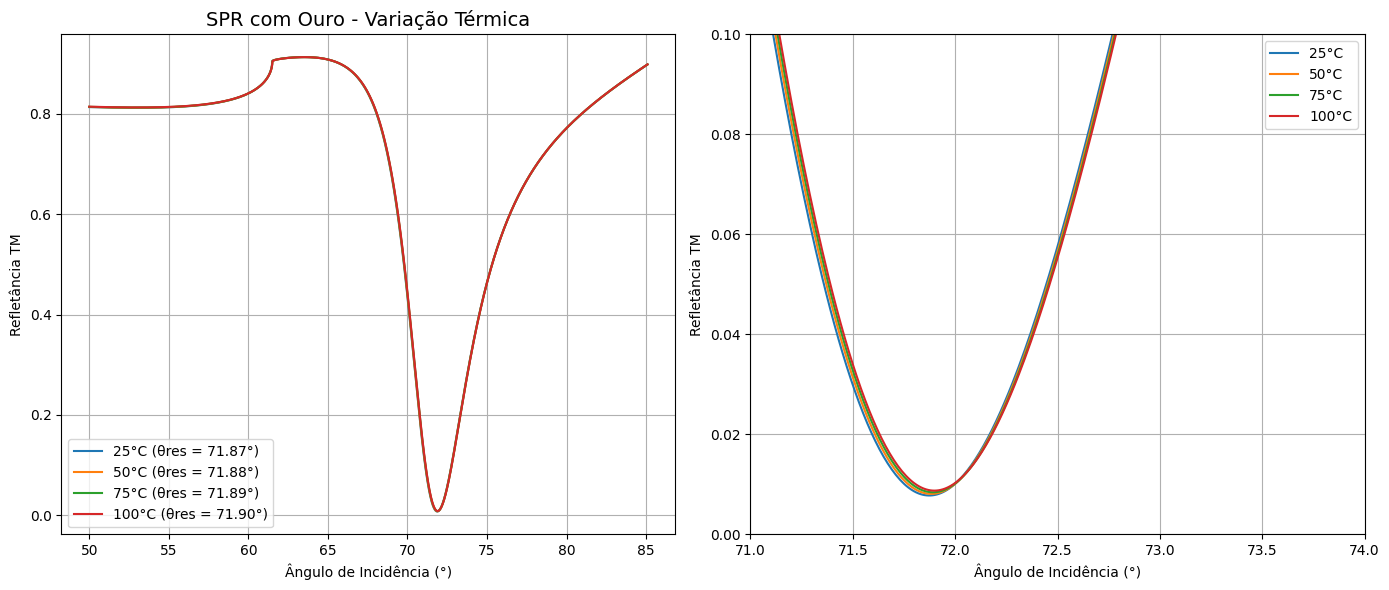

In [116]:
# variáveis anteriores
wavelength = 635e-9  # m
wavelength_microns = wavelength * 1e6
angle_range = np.arange(50, 85.1, 0.01) 

# Parâmetros para dilatação térmica do ouro
T0 = 293  # K (20°C)
temperaturas_K = np.array([298, 323, 348, 373])  # Temperaturas em Kelvin (25°C a 100°C)
temperaturas_C = temperaturas_K - 273.15

thickness_au = 50e-9  # espessura inicial do ouro
gamma_e = 14.3e-6  # 1/K
mu = 0.44  # Coef. de Poisson

gamma_prime = gamma_e * (1 + mu) / (1 - mu)

espessuras_au = thickness_au * (1 + gamma_prime * (temperaturas_K - T0))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for T_C, d_au in zip(temperaturas_C, espessuras_au):
    n_T = calc_n_BK7(T_C, n_bk7_exp, D0, D1, D2, E0, E1, lambda_0, wavelength_microns)
    n_au = get_metal_index("gold", wavelength)

    layers_temp = [
        {"name": "prisma", "type": "fixed", "index": n_T, "thickness": 500e-9},
        {"name": "gold", "type": "fixed", "index": n_au, "thickness": d_au},
        {"name": "h2o", "type": "other", "thickness": 500e-9}
    ]

    n_temp, d_temp = build_layer_stack(layers_temp, wavelength)
    theta_deg, Rp, theta_res = simulate_spr(n_temp, d_temp, wavelength, angle_range)
    min_Rp = np.min(Rp)

    print(f"Temperatura: {T_C:.0f}°C")
    print(f"Espessura do Ouro: {d_au*1e9:.4f} nm")
    print(f"Ângulo de Ressonância: {theta_res:.2f}°")
    print(f"Menor Reflectância (Rp): {min_Rp:.5f}")
    print("----------------------------------------")

    plt.plot(theta_deg, Rp, label=f'{T_C:.0f}°C (θres = {theta_res:.2f}°)')

plt.title("SPR com Ouro - Variação Térmica", fontsize=14)
plt.xlabel("Ângulo de Incidência (°)")
plt.ylabel("Refletância TM")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for T_C, d_au in zip(temperaturas_C, espessuras_au):
    n_T = calc_n_BK7(T_C, n_bk7_exp, D0, D1, D2, E0, E1, lambda_0, wavelength_microns)
    n_au = get_metal_index("gold", wavelength)

    layers_temp = [
        {"name": "prisma", "type": "fixed", "index": n_T, "thickness": 500e-9},
        {"name": "gold", "type": "fixed", "index": n_au, "thickness": d_au},
        {"name": "h2o", "type": "other", "thickness": 500e-9}
    ]

    n_temp, d_temp = build_layer_stack(layers_temp, wavelength)
    theta_deg, Rp, theta_res = simulate_spr(n_temp, d_temp, wavelength, angle_range)

    plt.plot(theta_deg, Rp, label=f'{T_C:.0f}°C')

plt.xlim(71, 74)
plt.ylim(0, 0.1)
plt.xlabel("Ângulo de Incidência (°)")
plt.ylabel("Refletância TM")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


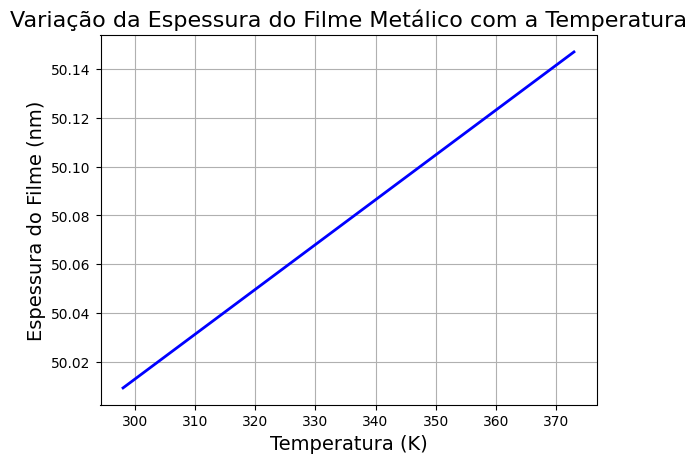

Temperatura: 25 K, Espessura: 50.0092 nm
Temperatura: 50 K, Espessura: 50.0552 nm
Temperatura: 75 K, Espessura: 50.1011 nm
Temperatura: 100 K, Espessura: 50.1471 nm


In [117]:
plt.plot(temperaturas_K, espessuras_au * 1e9, 'b-', linewidth=2)
plt.xlabel('Temperatura (K)', fontsize=14)
plt.ylabel('Espessura do Filme (nm)', fontsize=14)
plt.title('Variação da Espessura do Filme Metálico com a Temperatura', fontsize=16)
plt.grid(True)
plt.show()

for i, T in enumerate(temperaturas):
    print(f"Temperatura: {T} K, Espessura: {espessuras_au[i] * 1e9:.4f} nm")

### Espectro do Laser L635P5 – Discretização da Intensidade

Nesta etapa, foi analisado o espectro do laser **L635P5** a partir de dados discretos obtidos da intensidade da luz em função do comprimento de onda. A discretização transforma um sinal contínuo (espectro) em um **conjunto de amostras numéricas**, o que é fundamental para análise computacional.

Para realizar esse procedimento foi utilizado o site WebPlotDigitizer para obter os valores discretizados do gráfico continuo.

A partir dessa discretização, é possível aplicar técnicas de **interpolação**, como splines ou interpolações lineares, para estimar a intensidade em comprimentos de onda intermediários.


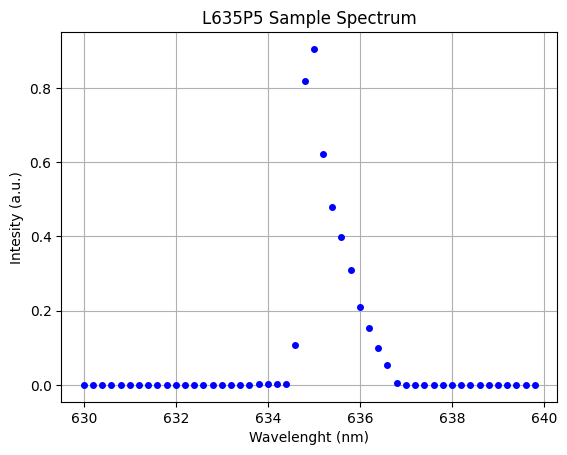

In [118]:
wavelengths = [630, 630.20, 630.40, 630.60, 630.80,
     631.00, 631.20, 631.40, 631.60,
     631.80, 632.00, 632.20, 632.40,
     632.60, 632.80, 633.00, 633.20,
     633.40, 633.60, 633.80, 634.00,
     634.20, 634.40, 634.60, 634.80,
     635.00, 635.20, 635.40, 635.60,
     635.80, 636.00, 636.20, 636.40,
     636.60, 636.80, 637.00, 637.20,
     637.40, 637.60, 637.80, 638.00,
     638.20, 638.40, 638.60, 638.80,
     639.00, 639.20, 639.40, 639.60,
     639.80]
intensity = [0, 0, 0,0, 0, 0,0, 0, 0, 0, 0, 0,0, 0, 0,0, 0, 0, 0, 
     0.0021868994564693827, 0.001782528728808697, 0.0017821519013119338, 
     0.0017999814450471098, 0.10658525170474657, 0.8184501706942788, 
     0.9051292555912355, 0.6208704695370435, 0.4781407593496571,
     0.3986983931491737, 0.30876002067888547, 0.21118463912755644, 0.15305810074519854,
     0.10067081028090429, 0.052818712247239094, 0.004799635492328927,
     0, 0, 0, 0,0, 0, 0,0, 0, 0,0, 0, 0, 0, 0]

plt.plot(wavelengths, intensity, 'o', color='blue', markersize=4, linewidth=2)
plt.title('L635P5 Sample Spectrum')
plt.xlabel('Wavelenght (nm)')
plt.ylabel('Intesity (a.u.)')
plt.grid(True)
plt.show()


## Cálculo da resposta do sensor SPR utilizando o modelo de Fresnel tradicional e o modelo modificado

Comparamos dois modelos de cálculo da reflectância em um sensor SPR:

- **Modelo Tradicional de Fresnel**: considera a luz excitante como monocromática, com um único comprimento de onda (neste caso, 635 nm). Esse modelo é adequado para situações onde a fonte de luz tem largura espectral muito estreita.

- **Modelo Modificado de Fresnel**: leva em conta a distribuição espectral da fonte de luz, ponderando a reflectância em cada comprimento de onda pela intensidade relativa da fonte ($\rho(\lambda)$). Essa abordagem é mais realista para fontes policromáticas e proporciona uma descrição mais precisa da curva de reflectância.

Para o modelo modificado, foi utilizada a fórmula:

$$
R_{p} = \frac{\int_{\lambda_I}^{\lambda_F} R_{m,\lambda} \rho(\lambda) d\lambda}{\int_{\lambda_I}^{\lambda_F} \rho(\lambda) d\lambda}
$$
onde:
- $R_{m,\lambda}$ é a reflectância monocromática para cada comprimento de onda;
- $\rho(\lambda)$ é a intensidade relativa da fonte em cada $\lambda$, obtida a partir da discretização experimental do espectro.

Ao final, os resultados de ambos os modelos são comparados graficamente, permitindo observar o efeito do espectro da fonte sobre a posição e a largura da ressonância SPR.


===== Resultados =====
Modelo Tradicional:
  Ângulo de Ressonância: 71.90°
  Refletância mínima:    0.0077

Modelo Modificado:
  Ângulo de Ressonância: 71.90°
  Refletância mínima:    0.0078


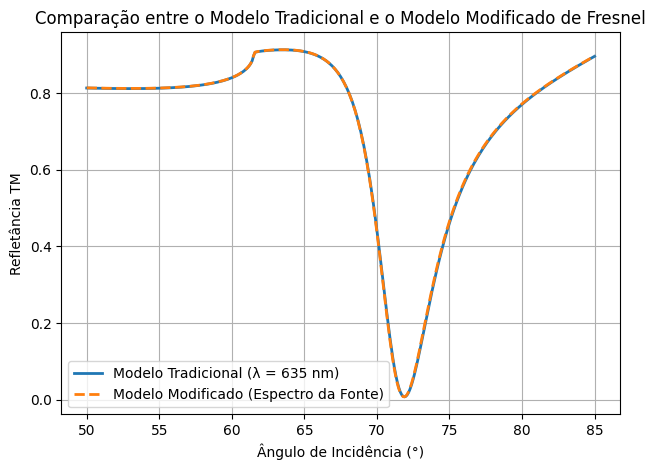

In [119]:
from scipy.integrate import simpson

wavelengths_nm = np.array(wavelengths)
intensity_norm = np.array(intensity) / np.max(intensity)  # Normalização da intensidade

angle_range = np.arange(50, 85.1, 0.1)  # Ângulos de incidência em graus

# Modelo tradicional: λ = 635 nm
lambda_ = 635e-9
n_au = get_metal_index("gold", lambda_)

layers = [
    {"name": "prisma", "type": "fixed", "index": n_bk7_exp, "thickness": 500e-9},
    {"name": "gold", "type": "fixed", "index": n_au, "thickness": 50e-9},
    {"name": "h2o", "type": "other", "thickness": 500e-9}
]

n_trad, d_trad = build_layer_stack(layers, lambda_)
theta_deg, Rp_trad, theta_res_trad = simulate_spr(n_trad, d_trad, lambda_, angle_range)
min_idx_trad = np.argmin(Rp_trad)
theta_res_trad = angle_range[min_idx_trad]
R_min_trad = Rp_trad[min_idx_trad]

# Modelo modificado: integração espectral
Rp_lambda_all = []
for wl_nm, I in zip(wavelengths_nm, intensity_norm):
    wl_m = wl_nm * 1e-9
    n_au = get_metal_index("gold", wl_m)

    layers_mod = [
        {"name": "prisma", "type": "fixed", "index": n_bk7_exp, "thickness": 500e-9},
        {"name": "gold", "type": "fixed", "index": n_au, "thickness": 50e-9},
        {"name": "h2o", "type": "other", "thickness": 500e-9}
    ]

    n_mod, d_mod = build_layer_stack(layers_mod, wl_m)
    _, Rp_lambda, _ = simulate_spr(n_mod, d_mod, wl_m, angle_range)

    Rp_lambda_all.append(Rp_lambda * I)  # pondera pela intensidade espectral
Rp_lambda_all = np.array(Rp_lambda_all)

Rp_mod = simpson(Rp_lambda_all, x=wavelengths_nm, axis=0) / simpson(intensity_norm, x=wavelengths_nm)

# Cálculo do ângulo de ressonância e refletância mínima (modelo modificado)
min_idx_mod = np.argmin(Rp_mod)
theta_res_mod = angle_range[min_idx_mod]
R_min_mod = Rp_mod[min_idx_mod]

print("===== Resultados =====")
print(f"Modelo Tradicional:")
print(f"  Ângulo de Ressonância: {theta_res_trad:.2f}°")
print(f"  Refletância mínima:    {R_min_trad:.4f}")
print()
print(f"Modelo Modificado:")
print(f"  Ângulo de Ressonância: {theta_res_mod:.2f}°")
print(f"  Refletância mínima:    {R_min_mod:.4f}")

plt.plot(angle_range, Rp_trad, label='Modelo Tradicional (λ = 635 nm)', linewidth=2)
plt.plot(angle_range, Rp_mod, label='Modelo Modificado (Espectro da Fonte)', linestyle='--', linewidth=2)
plt.title("Comparação entre o Modelo Tradicional e o Modelo Modificado de Fresnel")
plt.xlabel("Ângulo de Incidência (°)")
plt.ylabel("Refletância TM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()